<a href="https://colab.research.google.com/github/arijeetchoudhury100/handwritten_digits/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import tensorflow as tf
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Conv2D,Dense,GlobalAveragePooling2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler

In [79]:
#load the mnist data
(train_x,train_y),(test_x,test_y) = tf.keras.datasets.mnist.load_data()

In [80]:
#data statistics
NUM_CLASSES = 10
NUM_CHANNELS = 1
_,IMG_H,IMG_W = train_x.shape
print('No. of training samples:',len(train_x))
print('No. of testing samples:',len(test_x))
print('Image shape:',(IMG_H,IMG_W))
print('train_x shape:',train_x.shape)
print('test_x shape:',test_x.shape)
print('train_y shape:',train_y.shape)
print('test_y shape:',test_y.shape)

No. of training samples: 60000
No. of testing samples: 10000
Image shape: (28, 28)
train_x shape: (60000, 28, 28)
test_x shape: (10000, 28, 28)
train_y shape: (60000,)
test_y shape: (10000,)


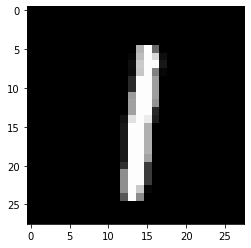

In [81]:
plt.imshow(train_x[40],cmap='gray')
#images are white on black background

In [82]:
#preprocess the data
#add channel dimension(1 in this case as we have grayscale images)
train_x = np.expand_dims(train_x,axis=3)
test_x = np.expand_dims(test_x,axis=3)

#normalize the images
train_x = train_x/255.0
test_x = test_x/255.0

#convert labels to one-hot encoding
train_y_oh = to_categorical(train_y,NUM_CLASSES)
test_y_oh = to_categorical(test_y,NUM_CLASSES)

In [83]:
print(train_y_oh.shape)
print(test_y_oh.shape)
print(train_x.shape)
print(test_x.shape)

(60000, 10)
(10000, 10)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


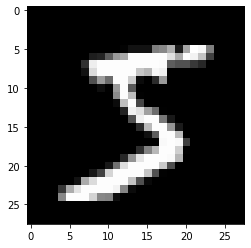

In [84]:
plt.imshow(train_x[0].reshape(28,28),cmap='gray')

In [85]:
#Build the CNN model
model = Sequential([
                    
        Conv2D(8,(3,3),use_bias=False,padding='same',input_shape=(28,28,1)),
        BatchNormalization(scale=False,center=True),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(16,(3,3),use_bias=False,padding='same'),
        BatchNormalization(scale=False,center=True),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(32,(3,3),use_bias=False),
        BatchNormalization(scale=False,center=True),
        Activation('relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(256,activation='relu'),
        Dropout(0.3),
        Dense(10,activation='softmax')

])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 8)         72        
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 8)         24        
_________________________________________________________________
activation_33 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 16)        1152      
_________________________________________________________________
batch_normalization_35 (Batc (None, 14, 14, 16)        48        
_________________________________________________________________
activation_34 (Activation)   (None, 14, 14, 16)       

In [86]:
#compile the model
opt = Adam(lr = 0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy']) 

In [91]:
#set up callbacks
model_check = ModelCheckpoint('mnist2.h5',monitor='val_accuracy',save_best_only=True)

def lr_decay(epoch):
  return 0.01*math.pow(0.666,epoch)
lr_decay_cb = LearningRateScheduler(lr_decay,verbose=True)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('val_accuracy') > 0.993:
      self.model.stop_training = True
my_cb = myCallback()

In [ ]:
#train the model
history = model.fit(train_x,train_y_oh,validation_data=(test_x,test_y_oh),epochs=100,batch_size=64,
                    callbacks=[lr_decay_cb,my_cb,model_check])

In [94]:
mnist = tf.keras.models.load_model('mnist.h5')
mnist.evaluate(test_x,test_y_oh)

313/313 [==============================] - 1s 3ms/step - loss: 0.0406 - accuracy: 0.9920


[0.04059333726763725, 0.9919999837875366]

In [96]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = mnist.predict_classes(test_x)
print(classification_report(test_y,predictions))
print(confusion_matrix(test_y,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1132    0    1    0    0    1    0    1    0]
 [   0    3 1023    0    0    0    0    4    2    0]
 [   0    0    2 1002    0    5    0    1    0    0]
 [   0    0    0    0  979   